# Set Up
Before we get started in earnest let's do a few python bookkeeping tasks to get our environment setup.

In [1]:
# This notebook was written in Python 2, where by default
# division by full integers gets rounded to full integers.
# To get the prefered behavior of recieving floating points
# during division, we need to do this import.
from __future__ import division

# Numpy is the core library we will be using for all of our
# computational work (as well as most scientific work done
# in the Python community).
# It allows us to create and run advanced operations on arrays
# and matrixes by leveraging compiled machine code and integration
# with the system's BLAS libraries.
import numpy as np

# A non-essential library for what we're doing, Matplotlib
# allows us to plot and draw graphs of our data so that we
# can visualize what we are accomplishing.
# Axes3d simply allows us to plot graphs in 3 dimensional space,
# which we'll do shortly
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# A bit of magic that tells matplotlib to draw graphs within our notebook
# instead of creating a new window.
# (Note that this is not actually valid Python, it's a piece of code only the IPython
# interperter will pick up on)
%matplotlib inline

# It's generally a good idea to explicitly set the random number generator so that our
# results are repeatable
np.random.seed(1)

# Exploring
Let's begin by exploring the data we will be working with and clearly defining what it is we want to do with it.

In [2]:
# np.array converts a traditional Python list into a numpy object
data = np.array(([1, 1, 1],
                 [1, 1, 0],
                 [1, 0, 1],
                 [1, 0, 0],
                 [0, 1, 1],
                 [0, 1, 0],
                 [0, 0, 1],
                 [0, 0, 0]))

labels = np.array([1, 1, 1, 1, 0, 0, 0, 0])

Right away we see that we are given two variables. `data` is a two dimensional matrix whose shape we can find by running...

In [3]:
data.shape

(8, 3)

Whereas the shape of `labels` is...

In [4]:
labels.shape

(8,)

Let's think of every row of `data` as an input to some function $f(X)$ and every element in `labels` as the corrosponding output of that function.
<table>
    <thead>
        <tr>
            <th>Input</th>
            <th>Output</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>`[1, 1, 1]`</td>
            <td>`1`</td>
        </tr>
        <tr>
            <td>`[1, 1, 0]`</td>
            <td>`1`</td>
        </tr>
        <tr>
            <td>`[1, 0, 1]`</td>
            <td>`1`</td>
        </tr>
        <tr>
            <td>`[1, 0, 0]`</td>
            <td>`1`</td>
        </tr>
        <tr>
            <td>`[0, 1, 1]`</td>
            <td>`0`</td>
        </tr>
        <tr>
            <td>`[0, 1, 0]`</td>
            <td>`0`</td>
        </tr>
        <tr>
            <td>`[0, 0, 1]`</td>
            <td>`0`</td>
        </tr>
        <tr>
            <td>`[0, 0, 0]`</td>
            <td>`0`</td>
        </tr>
    </tbody>
</table>

Or put another way: 
$$f([1, 0, 0]) = 1$$

$$f([0, 0, 1]) = 0$$

$$f([1, 1, 1]) = 1$$

$$f([0, 1, 1]) = 0$$
etc...

Viewed like this, we can quickly see what the relationship between the input and the output is, or rather what that ambigious function $f$ is doing. The output simply ignores the last two elements and returns the first. We can say this is a **linear**, where each element of the input affects the output independently of one other.

It would be trivial for us to manually write a function to mimmic $f(X)$

In [5]:
def f(x):
    return x[0]

Where for any given `x` we get a corrosponding label.

In [6]:
print f([1, 0, 1])
print f([0, 0 ,])
print f([1, 1, 1])

1
0
1


But a much more interesting mental exercise would be to try to devise a system in which the machine can deduce this relationship for us. Furthermore, is there a way to generalize the problem broadly enough so that this system can find the relationships between any arbitrary pieces of data?

# Training vs Testing
Before we can start writing our system we should take care to try to follow best practices, the most basic of which is to first seperate our data into two cateogories: a training data set, from which we'll actively work with and use to tune our system, and a testing data set, which we'll set aside and **only** use after we've trained and tuned our system to evaluate how well it preforms.

This distinction between training and testing data is important and something that will always be seen when doing almost any kind of data science or analysis work. The idea is to make sure that any results we find are legitamite and will work reasonably well "in the field" on data we've never seen before and hasn't just been fine tuned to work well only with the data we happen to have on hand. It would be trivial for anybody to write a program that can correctly label the small, defined set of data we have (just a few `if` statements), what we're tying to find is latent relationships within the data so that we can correctly operate on data we've never seen before. This scenerio of training a model to work really well on your training data to the detriment of working well on actual data is often referred to as **overfitting**.

(In this case, we just so happen to have every iteration of the data that can possibly exist [3 binary fields, 8 examples: $2^3 = 8$], however it's still a good practice to go over.)

In [7]:
# Creates an array from [0 : (len(data) - 1)] and randomly
# shuffles it. We will use this to shuffle our data and
# and our labels consistantly
shuffle = np.random.permutation(len(data))
data = data[shuffle]
labels = labels[shuffle]

# Split our variables into 2 halves, training and testing
train_data, test_data = np.split(data, 2)
train_labels, test_labels = np.split(labels, 2)

# Visualizing Our Data
We'll be staring at a lot of numbers. So many numbers that it's possible you'll find yourself lost in them, forgetting the meaning behind them, what we're trying to accomplish, and where to go next. On these occassions you'll find it's useful to represent those numbers in new, interesting ways just to keep yourself grounded in what you're actually looking at.

For now, lets take our data points and try plot them into 3 dimensional space, with the first column refering to the points X-axis, the second to the Y-axis, and the 3rd to the Z-axis.

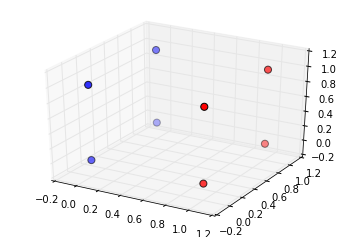

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=50, marker='o', c=['red' if x else 'blue' for x in labels==1])
plt.show()

Now we have a slightly better view of our data. To the left, marked with blue, are the points that are labelled 0 and to the right, marked in red, are the points that are labelled 1.

In fact, maybe it would help if we viewed this problem as simply one of classification. We have two classes, 0 and 1. What we would like to do is to deduce some way of looking at a point of data and saying in to which of these two categories it falls into.

One interesting way of doing this is to divide our 3 dimensional grid in such a way that we can say "if a point is in this part of the graph it is a 0, if it is in this other part it is a 1." Let's try visualizing this to get a sense of what this might look like.

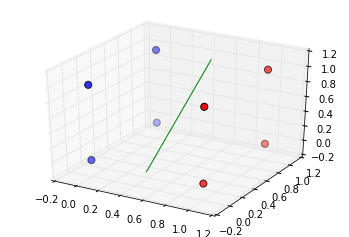

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=50, marker='o', c=['red' if x else 'blue' for x in labels==1])
ax.plot([.5, .5], [1, 0], [1, 0], c='green')
plt.show()

The graph is the same as before, only now we've drawn a green line dividing it in half. Everything to the left of this vector is of class 0, everything to the left is of class 1. Theoretically, we could plot a point anywhere we want onto this graph and easily determine which of these two classes it falls into.

In some sense we could say that our job is going to be to figure out just exactly where to draw that line.

This method of treating data as points in space and dividing the space is generally falls into the category of **Soft Vector Machines** or **SVMs** for short and is a subset of **linear classification**. Machine learning is very much an amaglamation of several computer science and statistical fields and we often find appropriations from other disciplines.

If this is how we'll be approaching this problem then we'll probably be doing a fair amount of graphing. Let's go ahead and put that code into a function so we can call it later.

In [10]:
def graph_points(points=data, identifiers=labels, line=None, title=''):
    # I can't remember off hand if lists are mutable in Python. If so,
    # then we don't want to define them in a function prototype as
    # it would persist across all calls to the function. So instead we
    # define the default thus:
    if line is None:
        line = ([.5, .5], [1, 0], [1, 0])
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=50, marker='o', c=['red' if x else 'blue' for x in identifiers==1])
    ax.plot(*line, c='green')
    plt.title(title)
    plt.show()

# Defining our $f$
We've now definied our problem as one of linear classification and that's a huge first step, but what exactly does that mean? We can say that each one of our rows of data can be defined by it's points in 3 dimensional space. We consider these three points our data's **features**, the properties of what we're observing. The fact that we're dealing with a feature size of 3 is an important concept, so lets save it to a variable so we can remember it.

In [11]:
# Our data is an 8x3 matrix, where 8 is the number of examples we
# have to work with and 3 is the number of features each one of those
# examples has
num_features = data.shape[1]

Linear classification attemtps to classify a piece of data into a class by using <a href="https://en.wikipedia.org/wiki/Linear_combination">**linear combination**</a> against the features of the data. The basic idea is that we can multiply our features by some defined set of values (also referred to as **weights** to determine which class it belongs to. Specifically we'll be classifying it into 1 of 2 classes. Again, this is an important fact we'll want to refer back to so let's save our number of classes to a variable as well.

In [12]:
num_classes = 2

With this in mind we can define our function as: $f(X, W) = X*W$

This translates pretty easily into code.

In [13]:
def f(x, w):
    # Remember, we're dealing with matrixes here, so we want to
    # take the dot product
    return x.dot(w)

But how do we define our weights? It turns out that this is a highly debatable topic and new methods for just exactly *how* we initialize our weights are still being explored. We can go over some of these methods later but for now we should be fine just setting out weights completely randomly.

But what shape should our weights be? Well we're looking to use a dot product to convert the 3 features of our data into knowledge about which of 2 classes it falls into. From this we can deduce that our shape should be

In [14]:
# Create a 3 x 2 matrix of random numbers
W = np.random.rand(num_features, num_classes)

Out of curiosity, let's plot out weights into our 3d graph and see if our SVM concept holds up.

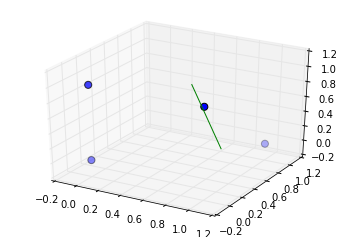

In [15]:
graph_points(points=train_data, line=(W[2], W[1], W[0]))

Well it doesn't divide our data very well. But let's keep this visiualization in the back of our minds for now and see if we can come back to it.

But enough analysis, let's run our function on our training data and see what the results looks like.

In [16]:
f(train_data, W)

array([[ 0.        ,  0.        ],
       [ 1.66878655,  1.17162805],
       [ 1.39562124,  0.62399972],
       [ 0.66974604,  0.93553907]])

We've gotten back a new matrix of size 4 x 2. This so happens to be the same as the number of training data x number of classes. So how can we interprate this? Well according to linear classification, it seems like what we've done is give a class relevency score for each one of our examples. Following this logic, the class with a higher score should be the correct one. Let's see how well we did with our randomly assigned weights.

In [17]:
scores = f(train_data, W)

# np.argmax simply returns the index of the max element. We want to find
# the max score across rows so we set axis=1
predict = np.argmax(scores, axis=1)

# We'll probably want to print accuracy information fairly often so let's
# make a function out of it
def accuracy(predicted, actual):
    print "Predicted classes: {}".format(predicted)
    print "Actual classes:    {}".format(actual)
    print '{}% accuracy'.format(np.sum(actual==predicted) / len(actual) * 100)
    
accuracy(predict, train_labels)

Predicted classes: [0 0 0 1]
Actual classes:    [0 1 1 0]
25.0% accuracy


25% accuracy isn't exactly a great result. Our input data is a fixed value that's given to us, we can't change it, which means that the only way to change the affectiveness of our function is to manipulate our weight values.

Here we used the percentage of accurate predictions to judge how well our model was working but is that the best strategy? For one thing it's based on a very binary judgment; either we're completely wrong or we're completely correct. Raw accuracy alone doesn't take into account how *confident* we are in our decision. Ideally, we'd like there to be a large margin between the score we reward the ground truth class and all of the other classes. Furthermore, whereas with accuracy we're currently limited to 5 disparate results (0%, 25%, 50%, 75%, 100%), it would be nice if we had a more linear score from which to determine if we're at least making small, gradual improvements to our system.

What we need is what is known as a **loss function**. A simple function, call it $L(s)$, that we can pass our calculated scores into and determine just exactly *how* wrong we were. In this kind of a function. a higher value would corrospond to a higher loss while a score close to zero indicates a more accurate result.

# The Loss Function
So what would such a function look like? It turns out there are dozens of algorithms that are in active use in machine learning, but for our purposes let's look at the Multiclass Support Vector Machine loss (as we're building our model based on SVMs using such a function seems to make sense).

The way SVM loss works is we iterate over every non correct class. We then check if the score for the correct class greater than that incorrect class by some predetrmined margin or $\Delta$. If it is we move on, if it isn't than we add the difference between the two to our overall loss.

Written out, that looks like:

$$L_i = \sum_{j\neq y_i} \max(0, s_{i_j} - s_{i_{y_i}} + \Delta)$$

Where $i$ is the ith data point and $j$ is the jth class. Note the $\max$ function here which is what is referred to as a **hinge loss**, basically it prevents us from inadvertantly subtracting from our loss.

The next question is then what do we set as our $\Delta$? We'll out of simplicity and convention we can just set it to 1 for now. Giving us the updated formula:

$$L_i = \sum_{j\neq y_i} \max(0, s_{i_j} - s_{i_{y_i}} + 1)$$

However this is not all, this simply calculates the loss for one particular piece of training data. We're interested in the loss across *all* the data points. For this we can simply take the average.

$$L = \frac{1}{N} \sum_i L_i$$

Where $N$ is the number of pieces of training data. Let's try to convert this algorithim into code.

In [18]:
def svm_loss(s, y):
    loss = 0.0
    
    # We want to iterate over all examples
    N = s.shape[0]
    for i in xrange(N):
        # The scores for that the ith data set
        s_i = s[i]
        
        # The correct class for the ith dataset
        y_i = y[i]
        
        for j in xrange(num_classes):
            # We're just interested in the incorrect classes
            if j == y_i:
                continue
                
            # Calculate the difference
            diff = s_i[j] - s_i[y_i] + 1
            
            # Our max "hinge loss" function
            if diff > 0:
                loss += diff
                
    # Average the results
    loss /= N
    return loss

Now let's calculate our loss for our previous scores.

In [19]:
svm_loss(scores, train_labels)

1.3836432657195892

Great, we now have a quantified number for just how *bad* our model is working. There is one logistical problem with our `svm_loss` function however; it's slow. While iterating over every example and class one by one is trivial with this miniscule sample of data, it won't scale very well. The simple truth is that Python is very slow, and we'd like to spend as little time inside of it during our mathematical functions. We want to try to **vectorize** our functions as much as possible. Vectorization in this context referring to performing operations on our matrixes as a whole rather than part by part. This will allow us to leverage the compiled machine code of numpy without having to jump back and forth to python too often as well as make it easier to port our code to CUDA or other GPU libraries if it so behooves us.

Our SVM loss function written in a vecotized form would look something like:

In [20]:
def svm_loss(s, y):
    N = s.shape[0]
    
    # We'll use this to access the correct class indices throughout our matrixes
    y_vec = range(N), y
    
    # An Nx1 matrix of the scores for the correct classes
    correct_scores = s[y_vec].reshape(-1, 1)
    
    # Note that we're preforming our calculations for *all* of our class scores, even the correct
    # ones. We'll resolve this shortly
    diff = np.maximum(0, s - correct_scores + 1.0)
    
    # We now zero out our correct class scores
    diff[y_vec] = 0
    
    # Sum and take the average of them all
    loss = np.sum(diff) / N
    return loss

In [21]:
svm_loss(scores, train_labels)

1.3836432657195892

As you can see, we're getting the same result as before only now we're taking advatange of our optimized matrix operations. The process of vectorization can be a pain but it's vital to get decent performance on larger data.

# Adding a bias
Now there's one more important fact that we've glossed over. Let's look at our scores again.

In [22]:
scores

array([[ 0.        ,  0.        ],
       [ 1.66878655,  1.17162805],
       [ 1.39562124,  0.62399972],
       [ 0.66974604,  0.93553907]])

Looking at the top row we see that we have zeros in both class scores. If we look at that example we might see why.

In [23]:
train_data[0]

array([0, 0, 0])

We've defined our $f$ to simply do a dot multiplication between our data and our weights. But because our example in this case is all zeros our system breaks down. We can see that we'll need to refactor our function before we move forward. We've left out an important step and that's to add what is referred to as a **bias** to our results. Our bias works a lot like our weights, they're just arbitrary values we can set to affect our class scores, in this case however we add them to our result rather than multipy. Let's initialize our bias's randomly, update our function, and see how it affects things.

In [24]:
b = np.random.rand(num_classes)

def f(x, w, bias):
    # Update our function to add our biases to our results
    return x.dot(w) + bias

scores = f(train_data, W, b)
print scores
print
accuracy(np.argmax(scores, axis=1), train_labels)
print
print svm_loss(scores, train_labels)

[[ 0.84631092  0.31327352]
 [ 2.51509747  1.48490156]
 [ 2.24193216  0.93727324]
 [ 1.51605695  1.24881259]]

Predicted classes: [0 0 0 0]
Actual classes:    [0 1 1 0]
50.0% accuracy

1.38364326572


We can see now, with our biases added, our class scores seem to be a bit healthier. Our accuracy has also increased up to 50% but this is just incidental and we can see that our loss is still, essentially, the same as before.

# Reducing Our Loss
With our $f$ cleaned up and a way of determining how great our loss is, let's investigate how we can best adjust our parameters to decrease our loss.

One approach might be to randomly change our weights and biases over and over again, keeping track of which configurations result in a lower loss. Let's see how something like this might look.

In [25]:
def random_train(x, y, iterations=1000):
    best_loss = None
    best_w = None
    best_b = None
    for it in xrange(iterations):
        w = np.random.rand(num_features, num_classes)
        bias = np.random.rand(num_classes)
        s = f(x, w, bias)
        loss = svm_loss(s, y)
        if best_loss is None or loss < best_loss:
            print loss
            best_loss = loss
            best_w = w
            best_b = bias
    return best_w, best_b

In [26]:
random_train(train_data, train_labels)

0.964338459092
0.773994713969
0.612139314651
0.561261482523
0.539855750807
0.524698682363
0.506173032411
0.495672067396
0.466604576575


(array([[ 0.23528204,  0.98547288],
        [ 0.08139846,  0.73699707],
        [ 0.20436332,  0.71783108]]), array([ 0.49352142,  0.11013057]))

This method seems to work, we are in fact slowly lowering our loss. But it doesn't seem like a particularly effective solution. We're completely at the mercy of the random number generator for one, for another we get very diminishing returns. The lower our loss becomes, the lower our chance of finding a better set of weights and biases. To illustrate this, let's try increasing our number of iterations and see how much better our results are.

In [27]:
random_train(train_data, train_labels, 100000)

1.22457531387
0.880547551318
0.872226392962
0.514590665906
0.499064698369
0.47383472647
0.447767171032
0.43662797113
0.434617853507
0.398270438666
0.37414102873
0.36986615494
0.36443038764


(array([[ 0.0104704 ,  0.94069441],
        [ 0.16796897,  0.89604205],
        [ 0.36596668,  0.85284643]]), array([ 0.67098167,  0.05892723]))

We've increased our number of iterations by 100 times and have only reduced our loss by a tenth. Maybe we should rethink our strategy.

Instead of randomly changing our weights each iteration it would be much better if we could deduce exactly how each individual cell of our weight matrix is affecting our loss and update it accordingly. One way of doing this is to iterate over every one of our weights, adjust by a slight amount, recalculate our loss and see how much it changes.  We would then need to do the same for our biases.

This is actually a fundementally great idea and, roughly, the path we will ultimately go down. But before we go through the trouble of writing out these complicated steps into code let's examine a little deeper what we're looking for. When you hear things such as "adjust by a slight amount" and measuring "change" there should be one mathematical concept raising alarms in your mind. We want to determine the rate of change of our loss with respect to our weights and biases. This is simply calculus. Instead of iterating and adjusting each of our weights and analyzing the change in loss (which is slow and impractical for systems with a large number of parameters), we only need to step through the derivatives of our function to mathematically deduce the rate of change of each of our paramaters. This rate of change across a matrix is known as a **gradiant**.

# Back Propagation
With our plan of attack set, we now need to differentiate the set of steps we've taken in deteremining our loss. This is also known as **back propagation**. Let's investigate this concept a little further and remind ourselves of a few calculus basics at the same time. (The following, like most of this notebook, is based heavly on <a href=http://cs231n.stanford.edu/syllabus.html>Stanford's CS231n</a>)

Let's take an example function:

$$f(x, y, z) = (x + y)*z$$

Graphed out this looks like:
![](http://i.imgur.com/pEfLGSZ.jpg)

Now if we fill in the values with $x=-2, y=5, z=-4$. We can fill in this graph like so:
![](http://i.imgur.com/GG1zWZ1.jpg)

This step is our **forward propagation**, where we plug our values in and step through each one of our gates calculating the results. But now we want to determine how each one of our variables (x, y, z) are contributing to our final score of -12 and here in lies our back propagation. We're looking for And what we're looking for is $\frac{\partial f}{\partial x}$, $\frac{\partial f}{\partial y}$, $\frac{\partial f}{\partial z}$.

So how do we do this? Well let's rewrite our function a little differently:
$$q = x + y$$
$$f = q * z$$

From here we can write up a few basic calculus derivatives:
$$\frac{\partial q}{\partial x} = 1 \hspace{1in}\frac{\partial q}{\partial y} = 1
\\
\frac{\partial f}{\partial q} = z \hspace{1in}\frac{\partial f}{\partial z} = q$$

Now to tie all of these declerations let's introduce our workhorse, the **chain rule** which states:
$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} * \frac{\partial q}{\partial x}$$
Using this simple but effective rule, we can step backwards throughout our graph, calculating the derivative at each gate and simply multiplying it by the local derivative of each subsequant gate until we reach our parameters.

![](http://i.imgur.com/c38VQmn.png)
With just a little bit of simple math we see that our x and y values have a negative affect on our end result while our z value has a positive.

What's more, we can see how using the chain rule we might code modular components to build our networks and which handle both their forward and backwards propagation. In fact, if you look at the source code for popular deep learning libraries such as Torch, Caffe, or TensorFlow they all work precisly this way.

So what would a graph of our system look like?
![](http://i.imgur.com/lblYqX4.png)
We've already differentiated the $+$ and $*$ gates. So now we simply need to find the derivative of our loss function and we can simply flow backwards using the chain rule to get the gradiants of our weights and biases.

To get ourselves a bit more comfortable with calclus we'll walk through the differentiation step by step.
We're looking for:

$$\frac{\partial}{\partial s_i} \sum_{j\neq y_i} \max(0, s_{i_j} - s_{i_{y_i}} + 1)$$

To help us with this differentiation let's remind ourselves of a few things that may come in handy with this function. 
Remember that a derivative is linear so the derivative of a sum is the sum of the derivative, so we can say:
$$\frac{\partial}{\partial x} \sum x = \sum \frac{\partial}{\partial x} x$$

We can therefore get that sigma out of the way for now:
$$\sum_{j\neq y_i} \frac{\partial}{\partial s_i} \max(0, s_{i_j} - s_{i_{y_i}} + 1)$$

Now what about that max function?

$$\frac{\partial}{\partial s_i} \max(0, x + 1) = \frac{\partial x + 1}{\partial x}*\mathbb{1}(x + 1 > 0)$$

Where the $\mathbb{1}$ symbol is the indicator function which equals 1 if the conditional inside is true and 0 if it is false. This derivative might require a bit of explaination but it does make sense. We're saying that the rate of change of $\max(0, x + 1)$ is the derivative of $x + 1$ *only* if $x + 1$ is greater than zero. If it's less than zero, then that max function makes sure that we have no rate of change at all.

With this in mind we can then say that our derivative is:
$$\frac{\partial L_i}{\partial s_i} = \frac{\partial s_{i_j} - s_{i_{y_i}} + 1}{\partial s_i} * \mathbb{1}(s_{i_j} - s_{i_{y_i}} + 1)$$

Okay, we're making progress. We've gotten our complicated differntiation with sigmas and maxes down to a place where we only now need to determine:

$$\frac{\partial}{\partial s_i}s_{i_j} - s_{i_{y_i}} + 1$$

The $+1$ drops out right away as it doesn't affect our rate of change leaving us with:
$$\frac{\partial}{\partial s_i}s_{i_j} - s_{i_{y_i}}$$

We want to look at this from two scenerios, when we're trying to find the derivative with respect to the correct class score and the incorrect score. We can then see...
$$\frac{\partial}{\partial s_{i_{y_i}}} s_{i_j} - s_{i_{y_i}} = -1$$
and
$$\frac{\partial}{\partial s_{i_j}} s_{i_j} - s_{i_{y_i}} = 1$$

Now that sigma actually falls out altogether for $\frac{\partial}{\partial s_{i_j}}$ because the rate of change of $s_{i_{y_i}}$ is affected by all non correct class scores while $s_{i_{j}}$ is only affected by itself. This all gives us our final results.
$$\frac{\partial}{\partial s_{i_{y_i}}} -\sum_{j\neq y_i} \mathbb{1}(s_{i_j} - s_{i_{y_i}} + 1)$$
and
$$\frac{\partial}{\partial s_{i_{j}}} \mathbb{1}(s_{i_j} - s_{i_{y_i}} + 1)$$

We can see that, because of that indicator function, our gradiant actually makes a lot of use of things we compute in the forward pass of our svm_loss function. Because our loss function is the gate of our graph, let's rewrite our function so that it now returns both our loss score and our gradiant with respect to our scores.

In [28]:
def svm_loss(s, y):
    N = s.shape[0]
    
    # We'll use this to access the correct class indices throughout our matrixes
    y_vec = range(N), y
    
    # An Nx1 matrix of the scores for the correct classes
    correct_scores = s[y_vec].reshape(-1, 1)
    
    # Note that we're preforming our calculations for *all* of our class scores, even the correct
    # ones. We'll resolve this shortly
    diff = np.maximum(0, s - correct_scores + 1.0)
    
    # We now zero out our correct class scores
    diff[y_vec] = 0
    
    # Sum and take the average of them all
    loss = np.sum(diff) / N
    
    # The derivative of our scores is the same size as our scores
    d_s = np.zeros_like(s)
    
    # The inside of our indicator function is the same as the result of our diff
    ind = diff
    
    # Handle s[i[j]]s
    d_s[ind > 0] = 1
    
    # Now we handle the s[i[y[i]]]s
    col_sum = np.sum(ind > 0, axis=1)
    d_s[np.arange(N), train_labels] -= col_sum
    
    # Take the average like we did for the loss
    d_s /= N
    return loss, d_s

Now we can see what the gradiant of our scores is.

In [29]:
loss, d_scores = svm_loss(scores, train_labels)
print d_scores

[[-0.25  0.25]
 [ 0.25 -0.25]
 [ 0.25 -0.25]
 [-0.25  0.25]]


We now have a matrix that maps how much, and in which direction, each cell of our scores variable affects our final loss. For instance we can see that element `[0][0]` has a -0.25 affect on our loss while `[0][1]` has a +0.25 affect on our loss. For fun let's try manually manipulating our scores to see if we can artificually lower our loss. Since `[0][0]` has a negative influence on our loss we want to *increase* that field, and because `[0][1]` has the tendency to inflate our loss, we want to *decrease* its value.

In [30]:
print "Prev loss: {}".format(loss)
mod_scores = scores
mod_scores[0][0] += .5
mod_scores[0][1] -= .5
print "Updated loss: {}".format(svm_loss(mod_scores, train_labels)[0])

Prev loss: 1.38364326572
Updated loss: 1.26690261566


As you can see, using our gradient we were able to figure out exactly what needed to be changed in order to reduce our loss. What we did actually makes completely sense if you think about it. Let's look at the correct label for our first piece of training data:

In [31]:
print train_labels[0]

0


The correct class for the example is 0, so obviously when we manually adjusted the scores so that the score for class 0 was higher and the score for 1 was lower we reduced our loss. The important thing is that we were able to figure mathematically deduce this relationship without having to rely on trial and error. Calculus is a powerful thing.

But knowing the gradient of the scores doesn't directly help us. We don't specify the scores ourselves, we specify our weights and biases and get our scores in return. What we want is our gradient with respect to our weights and with respect to our biases. So let's continue our back propagation and look back at our graph.

![](http://i.imgur.com/I0SPIyW.png)

We've just found $\frac{\partial loss}{\partial scores}$, and $\frac{\partial scores}{\partial b}$ is simply a function of addition which as we already pointed out is simply 1. All we need to do to get the gradiant of our biases is morph our incoming gradiant (d_scores) to fit our bias matrix. 

In [32]:
d_b = np.sum(d_scores, axis=0)

Now what about our weights? Well our gradiant propagates back to our multipy gate through the same addition gate we went through for our biases, meaning we simply multipled d_scores by 1. Now the derivative X\*W with respect to X is simply W, and the derivative of X\*W with respect to W is just X or to put it into leibniz notation
$$\frac{\partial X*W}{\partial W} =  x$$
And because we've been folloing the chain rule we know:
$$\frac{\partial loss}{\partial W} = \frac{\partial X*W}{\partial W} * dscores$$
The gradiant of our W is simply the gradiant of our scores multiplied by our input data.

In [33]:
# The '.T' is just a simple matrix transform, rows becomes columns
# And columns becomes rows, this adjusts the shape to allow us to do
# a dot product
d_W = train_data.T.dot(d_scores)
print d_b
print
print d_W

[ 0.  0.]

[[ 0.5  -0.5 ]
 [ 0.25 -0.25]
 [ 0.    0.  ]]


The same way we were previously able to determine how our scores were affecting our final loss, we can now see exactly how each of our biases and weights are affecting our final outcome. In this case, it doesn't look like our bias isn't doing much of anything while there's a good amount of information in our d_W.

Now, the same way we practiced with our scores, let's see if we can update our weights and biases using this information to reduce our loss.

In [34]:
learning_rate = .01
b -= learning_rate * d_b
W -= learning_rate * d_W

We subtract a hundredth of our gradiant from our biases and weights. This will cause our negative rate of changes to increase the corrosponding value and the positive rates of changes to decrease their values.

But what is that learning rate variable? It's important to remember what we are calculating with our gradient, and calculus and general. We are simply finding out the rate of change of our functions at this precisise, infinitesimally  small range of time. At some later point in the function the rate of change may very well (and certianly will for non-linear functions) change. Think of it as finding your way across a mountain with your eyes closed. You can feel the slope under your feet where you stand and only want to make small little steps because if you make too big of a leap there's a good chance the slope will change under you.

As for how we actually set out learning late, it is a **hyper parameter**, we can set it to whatever we want to get the best results. Generally, you'll have to weigh the pros and cons of a smaller learing rate which could take a long time to converge with a larger learning rate which should work faster but provide more hectic results.

Note that this is far from the only way to update our weights using our gradient. There are several algorithims for doing this that work with varying degrees of success, this is just the simplest one known as **stochastic gradient descent** or **SGD**.

In [35]:
print "Prev loss: {}".format(loss) 
scores = f(train_data, W, b)
new_loss = svm_loss(scores, train_labels)[0]
print "Updated loss: {}".format(new_loss)
print "Difference: {}".format(loss - new_loss) 

Prev loss: 1.38364326572
Updated loss: 1.37739326572
Difference: 0.00625


We've succesfully reduced our loss by simply tweaking our weights and biases. This is a very important moment because at this point we have successfully gone through the pipeline that affectivly drives all modern (at least neural network) supervised machine learning. The functions might get expanded and our derivatives more complicated but it always boils down to these central steps. A function to make a prediction; a function to calculate success; and a function to update the parameters to our prediction.

# Training
So far we've just been working line by line. Let's put all of this into an iteration and see just how low we can get our loss. At the same time, let's visualize what's happening with our weights as we iterate. Finally we can see if all of this has been worth while and see if we can accuratly predict all of our results.

Loss: 1.37739326572


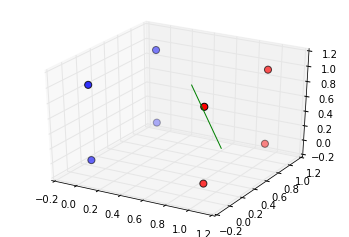

Loss: 0.75239326572


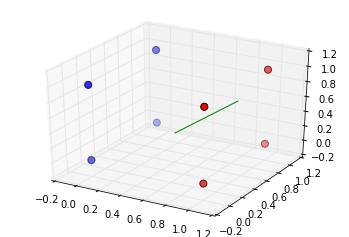

Loss: 0.304978534655


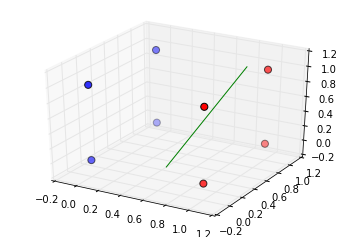

Loss: 0.121987884593


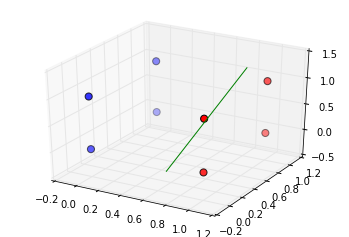

Loss: 0.0206889085622


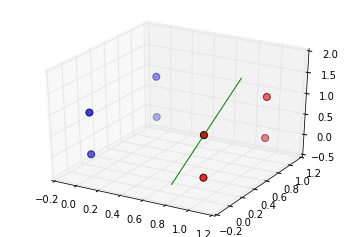

Loss: 0.0


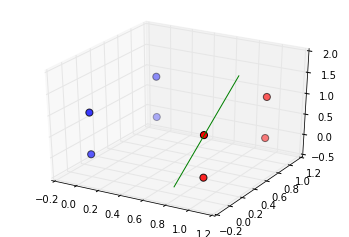

In [36]:
learning_rate = .01

for it in xrange(6000):
    scores = f(train_data, W, b)
    loss, d_scores = svm_loss(scores, train_labels)
    
    if it % 100 == 0 or not loss:
        print "Loss: {}".format(loss)
        graph_points(line=(W[2], W[1], W[0]))
        
    if not loss:
        break
    
    d_b = np.sum(d_scores, axis=0)
    d_W = train_data.T.dot(d_scores)
    b -= learning_rate * d_b
    W -= learning_rate * d_W

It looks like we were able to get our loss all the way down to 0. Also if you look at our visualization you'll see that the line our weights draw roughly learns to take the form that we looked at at the beginning of the notebook. 
Now let's see how well our model performs on our training data.

In [37]:
train_scores = f(train_data, W, b)
train_predict = np.argmax(train_scores, axis=1)
accuracy(train_predict, train_labels)

Predicted classes: [0 1 1 0]
Actual classes:    [0 1 1 0]
100.0% accuracy


Well you can't ask for more than 100% accuracy. Now the moment of truth, how well does our model perform on our *testing data*? Keep in mind, these are all examples that our model has never seen before and has not had the opportunity to learn from.

In [38]:
test_scores = f(test_data, W, b)
test_predict = np.argmax(test_scores, axis=1)
accuracy(test_predict, test_labels)

Predicted classes: [1 0 1 0]
Actual classes:    [1 0 1 0]
100.0% accuracy


Again, 100% accuracy. The data itself might be small and humble but we've done something fundementally very cool. Using a just a little bit of data we were able to train our system to find the relationships between input and output and accuratly make predictions against data its never seen before.

It might seem like a lot of work, and it is, but go ahead and change the labels to reflect any other linear relationship and our system will work just as well.

We're not even dependent on this dataset. Next we'll see how well this same model works on image data and then we'll examine how to modify it to handle more complicated relationships. But it will always follow this same base model.